<a href="https://colab.research.google.com/github/huynguyen1999/comic-scraper/blob/master/Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

In [24]:
!pip3 install cloudscraper
!pip3 install bs4
# !pip3 install opencv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from datetime import datetime, timedelta
from google.colab.patches import cv2_imshow
from bs4 import BeautifulSoup
import traceback
import cloudscraper
import numpy as np
import pandas as pd
import re
import shutil
import os
import json
import cv2

# Target Analysis

**init**

In [3]:
base_url = "http://www.nettruyenco.com/?page=1"
scraper = cloudscraper.create_scraper(delay=10, browser={"browser": 'chrome', "custom": "ScraperBot/2.0"})
response = scraper.get(base_url).text
soup = BeautifulSoup(response, "html.parser")

### explore

**title**

In [4]:
soup.select('title')

[<title>
 	Đọc truyện tranh online - Truyện gì cũng có - NetTruyen
 </title>]

**comic_card**

In [5]:
comic_card = soup.select('.row > .item')[0]

**comic cover**

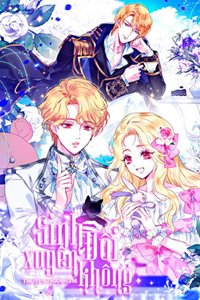

In [6]:
cover_path = "http:" + comic_card.select('img.lazy')[0].get('data-original')
resp = scraper.get(cover_path, stream=True).raw
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
cv2_imshow(image)

**information**

In [7]:
comic_title = comic_card.select('div.title')[0].text
comic_details = comic_card.select('div.message_main')[0].text
print(f"""
Title: {comic_title}
{comic_details}
Introduction: {comic_card.select('div.box_text')[0].text}
""")


Title: Sinh đôi xuyên không


Tên khác:Song Sinh Trọng Sinh

Thể loại:Comedy, Manhwa, Ngôn Tình, Romance, Truyện Màu, Xuyên Không

Tình trạng:Đang tiến hành

Lượt xem:16.460.814

Bình luận:4.213

Theo dõi:104.215

Ngày cập nhật:6 ngày trước

Introduction: Tên của 2 con sẽ là Arjen và Arien.
Chúng tôi giống như bất kỳ cặp song sinh đều đi học đến trường, nhưng sau đó chúng tôi mất mạng vì một tai nạn và được trọng sinh vô một thế giới khác.
Và chúng tôi sống trong một cung điện bỏ hoang cùng với người mẹ ngược đãi và một người cha hoàng đế lạnh lùng không bao giờ đến thăm chúng tôi.
Nhưng vào sinh nhật lần thứ 5 của chúng tôi ... Nhà vua đột nhiên muốn nhìn thấy con cái của mình.
"Sao đột ngột thế?"
Rốt cuộc hoàng đế có ý định gi?



# Implementation

## Comment

In [140]:
class Comment:
  def __init__(self, user=User(), time="", chapter="", content="", replies=[]):
    self.user = user
    self.time = time
    self.chapter = chapter
    self.content = content
    self.replies = replies
  
  def __str__(self):
    string = f"[User] {self.user} at {self.time} on {self.chapter}\n"\
             f"[Content] {self.content}"
    if len(self.replies):
      for reply in self.replies:
        string += "\n" + str(reply)
    return string

## User

In [141]:
class User:
  all_users = set([])
  def __init__(self, name="", avatar="", level="", experience=""):
    self.name = name
    self.avatar = avatar
    self.level = level 
    self.experience = experience
    User.all_users.add(self)
  def __str__(self):
    return f"Name: {self.name} | Level: {self.level} | EXP: {self.experience}"

## Comic

In [147]:
class Comic:
  def __init__(self, detail, chapters, comments=[]):
    # comments (next challenge) -> get list of comments after clicking any comment pagination buttons -> decode from unicode to normal -> soup
    self.detail = detail
    self.chapters = chapters
    self.comments = comments
    
  def __str__(self):
    output = "\nDETAIL:"
    for k, v in self.detail.items():
      output += f"\n\t{k}: {v}\n"
    
    output += "\nCHAPTERS:"
    for chapter_no, chapter_local_path in enumerate(self.chapters):
      output +=  f"\n\tChapter {chapter_no}: {chapter_local_path}"
    
    output += "\nCOMMENTS:"
    for comment_no, comment in enumerate(self.comments):
      output += f"\n\tComment {comment_no}: {str(comment)}"

    return output
  
  def log(self):
    with open(f"{self.detail['comic_local_path']}/log.txt", "w") as log_file:
      log_file.write(str(self))

## Extractor

In [143]:
class Extractor:
  @staticmethod
  def extract_user_from_comment(comment_soup):
    name = comment_soup.select('.authorname')[0].text
    try:
      level = comment_soup.select('.member')[0].text
      experience = comment_soup.select('.progress-bar')[0].get('style').split(':')[-1]
    except Exception as e:
      level = "-1"
      experience ="-1"
    avatar = "https:" + comment_soup.find('img')['src']
    return User(name=name, level=level,experience=experience, avatar=avatar)

  @staticmethod
  def extract_comment(comment_soup):
    user = Extractor.extract_user_from_comment(comment_soup)
    time = comment_soup.find('abbr').get('title')
    chapter_soup = comment_soup.select('.cmchapter')
    chapter = "-1" if len(chapter_soup) == 0 else chapter_soup[0].text
    content = comment_soup.select('.summary')[0].encode_contents()
    replies = []
    replies_box_soup = comment_soup.select('.jcmt')
    if len(replies_box_soup):
      replies_soup = replies_box_soup[0].select('.jsummary')
      for reply_soup in replies_soup:
        full_reply_soup= reply_soup.parent
        reply = Extractor.extract_comment(full_reply_soup)
        replies.append(reply)
    return Comment(user=user, time=time, chapter=chapter, content=content, replies=replies)

  @staticmethod
  def extract_comic_detail(comic_detail_soup):
    
    detail = {}
    detail['title'] = comic_detail_soup.select('.title-detail')[0].text
    detail['last_update_date'] = re.findall("\d{2}:\d{2} \d{2}/\d{2}/\d{4}",
                                            comic_detail_soup.select('time.small')[0].text)[0]
    detail['cover_source'] = "https:" + comic_detail_soup.select('.col-image > img')[0].get('src')
    detail['author'] = comic_detail_soup.select('li.author')[0].text.lstrip('\n').split('\n\n')[-1].rstrip('\n')
    detail['status'] = comic_detail_soup.select('li.status')[0].text.lstrip('\n').split('\n\n')[-1].rstrip('\n')
    detail['categories'] = comic_detail_soup.select('li.kind')[0].text.lstrip('\n').split('\n\n')[-1].rstrip('\n')
    detail['n_views'] = comic_detail_soup.find(text=re.compile('Lượt xem')).parent.find_next_sibling().text
    detail['rate_value'] = comic_detail_soup.find('span', {'itemprop':'ratingValue'}).text
    detail['rate_count'] = comic_detail_soup.find('span', {'itemprop':'ratingCount'}).text
    detail['n_follows'] = comic_detail_soup.select('.follow > span > b')[0].text
    return detail

## ComicScraper


In [148]:
class ComicScraper:
  base_url = "http://www.nettruyenco.com/tim-truyen?status=-1&sort=15"
  headers={"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.0.0 Safari/537.36",
           "Referer": "http://www.nettruyenco.com/"}
  # check network tab in inspect to figure out
  get_comments_url = "http://www.nettruyenco.com/Comic/Services/CommentService.asmx/GetList?&orderBy=0&chapterId=-1&parentId=0"#?comicId=X?&pageNumber=Y 
  
  def __init__(self):
    self.scraper = cloudscraper.create_scraper(delay=5, 
                                               browser = {'browser': 'chrome',
                                                          "custom": "ScraperBot/2.0"})
    self.scraped_comics = []

  def scrape_comic_site(self, from_page=1, to_page=1):
    print(f"Start scraping new comics at{base_url} from page {from_page} to page {to_page}...")
    for page in range(from_page, to_page + 1):
      comic_list_url = f"{ComicScraper.base_url}&page={page}"
      list_scraped_comics = self.scrape_comic_list(comic_list_url)
      self.scraped_comics.extend(list_scraped_comics)

  def scrape_comic_list(self, comic_list_url):
    print(f"\n\n\n--> Scraping comic list at {comic_list_url}")
    list_scraped_comics = []
    response = self.scraper.get(comic_list_url)
    soup = BeautifulSoup(response.content, "html.parser")
    comic_cards_soup = soup.select('.row > .item')
    for comic_card_soup in comic_cards_soup:
      comic_url = comic_card_soup.select('.jtip')[0].get('href')
      scraped_comic = self.scrape_comic(comic_url)
      list_scraped_comics.append(scraped_comic)
    return list_scraped_comics

  def scrape_comic(self, comic_url, comics_local_path='./comics', from_chapter=1, to_chapter=1):
    if not os.path.exists(comics_local_path): os.makedirs(comics_local_path) 
    print(f"\n----> Scraping comic at {comic_url}")
    response = self.scraper.get(comic_url)
    soup = BeautifulSoup(response.content, "html.parser")
    # detail
    comic_detail_soup = soup.select('#item-detail')[0]
    comic_detail = Extractor.extract_comic_detail(comic_detail_soup)
    # chapters
    chapter_list_soup = soup.select('.list-chapter')[0].select('li.row')[::-1][from_chapter: to_chapter+1]
    comic_detail['comic_local_path'] = f"{comics_local_path}/{comic_detail['title']}"
    scraped_chapters = self.scrape_chapters(chapter_list_soup, comic_detail['comic_local_path'])
    # comments
    comic_id = comic_url.split('-')[-1][:-1]
    n_comments = int(soup.select('.comment-count')[0].text.replace('.',''))
    scraped_comments = self.scrape_comic_comments(comic_id, n_comments)
    return Comic(comic_detail, scraped_chapters, scraped_comments)

  def scrape_chapters(self, chapter_list_soup, comic_local_path):
    scraped_chapters = []
    print(f"------> Scraping {len(chapter_list_soup)} chapters...")
    for chapter_soup in chapter_list_soup:
      chapter_url = chapter_soup.find('a').get('href')
      # uncomment to scrape chapters
      scraped_chapter = self.scrape_chapter(chapter_url, comic_local_path)
      # scraped_chapter = None
      scraped_chapters.append(scraped_chapter)
    return scraped_chapters

  def scrape_chapter(self, chapter_url, comic_local_path):
    if not os.path.exists(comic_local_path): os.makedirs(comic_local_path)
    print(f"-------->Scraping a chapter at {chapter_url}")
    response = self.scraper.get(chapter_url)
    soup = BeautifulSoup(response.content, "html.parser")
    chapter_name = soup.select('h1.txt-primary')[0].text.split('-')[-1].lstrip()
    chapter_local_path = f"{comic_local_path}/{chapter_name}"
    if not os.path.exists(chapter_local_path): os.makedirs(chapter_local_path)
    chapter_pages_soup = soup.select('.page-chapter')
    self.scrape_pages(chapter_pages_soup, chapter_local_path)
    return chapter_local_path

  def scrape_pages(self, chapter_pages_soup, chapter_local_path):
    for chapter_page_soup in chapter_pages_soup:
      chapter_page_url = "https:" + chapter_page_soup.find('img').get('data-cdn')
      try:
        image_raw = self.scrape_chapter_page(chapter_page_url)
        with open(f"{chapter_local_path}/{chapter_page_soup['id'][5:]}.jpg", "wb") as image:
          shutil.copyfileobj(image_raw, image)
      except Exception as e:
        print(f"Error: {e}")

  def scrape_chapter_page(self, chapter_page_url):
    image_raw = self.scraper.get(chapter_page_url,headers=self.headers,stream=True).raw
    return image_raw

  def scrape_comic_comments(self, comic_id, n_comments, from_page=1, to_page=2):
    print(f"------> Scrape comic with id={comic_id} from page={from_page} to page={to_page}")
    comment_list_page = from_page
    comment_count = 0
    comic_comments = []
    while comment_count < n_comments and comment_list_page <= to_page:
      comment_list_url = f"{ComicScraper.get_comments_url}&comicId={comic_id}&pageNumber={comment_list_page}" 
      comments, list_comment_count = self.scrape_comment_list(comment_list_url)
      comic_comments.extend(comments)
      comment_count += list_comment_count
      comment_list_page += 1
    return comic_comments

  def scrape_comment_list(self, comment_list_url):
    print(f"--------> Scraping comments at {comment_list_url}")
    response = self.scraper.get(comment_list_url).json()
    comments = []
    comment_count = 0
    if response['success'] == True:
      content = response['response']
      # print(content)
      soup = BeautifulSoup(content, "html.parser")
      comments_soup = soup.select('.journalrow')
      for comment_soup in comments_soup:
        comment = Extractor.extract_comment(comment_soup)
        n_replies = len(comment.replies)
        comment_count = comment_count + n_replies + 1
        comments.append(comment)
    return comments, comment_count

# Scrape new comics from https://nettruyenco.com 

In [149]:
nettruyen_scraper = ComicScraper()
nettruyen_scraper.scrape_comic_site()

Start scraping new comics athttp://www.nettruyenco.com/?page=1 from page 1 to page 1...



--> Scraping comic list at http://www.nettruyenco.com/tim-truyen?status=-1&sort=15&page=1

----> Scraping comic at http://www.nettruyenco.com/truyen-tranh/dua-be-do-khong-phai-con-anh-63160
------> Scraping 1 chapters...
-------->Scraping a chapter at http://www.nettruyenco.com/truyen-tranh/dua-be-do-khong-phai-con-anh/chap-2/863928
------> Scrape comic with id=6316 from page=1 to page=2
--------> Scraping comments at http://www.nettruyenco.com/Comic/Services/CommentService.asmx/GetList?&orderBy=0&chapterId=-1&parentId=0&comicId=6316&pageNumber=1
--------> Scraping comments at http://www.nettruyenco.com/Comic/Services/CommentService.asmx/GetList?&orderBy=0&chapterId=-1&parentId=0&comicId=6316&pageNumber=2

----> Scraping comic at http://www.nettruyenco.com/truyen-tranh/dung-den-cua-hang-cua-ac-nu-63159
------> Scraping 1 chapters...
-------->Scraping a chapter at http://www.nettruyenco.com/truyen

**show scraped comic**


In [150]:
comic = nettruyen_scraper.scraped_comics[10]
print(comic)


DETAIL:
	title: Bạn Gái Tôi là Người Ngoài Hành Tinh

	last_update_date: 13:14 05/06/2022

	cover_source: https://st.nettruyenco.com/data/comics/89/ban-gai-toi-la-nguoi-ngoai-hanh-tinh.jpg

	author: Rie Ato

	status: Đang tiến hành

	categories: Comedy - Manga - Romance - School Life

	n_views: 38.845

	rate_value: 3.5

	rate_count: 54

	n_follows: 1.217

	comic_local_path: ./comics/Bạn Gái Tôi là Người Ngoài Hành Tinh

CHAPTERS:
	Chapter 0: ./comics/Bạn Gái Tôi là Người Ngoài Hành Tinh/Chapter 2
COMMENTS:
	Comment 0: [User] Name: Minamoto Akari | Level: Cấp 1 | EXP: 0% at 12/31/2021 9:52:45 AM on Chapter 5
[Content] b'nh\xc3\xacn m\xe1\xba\xb7t Asashi k\xc3\xaca\xc2\xa0<br/>m\xc3\xacnh \xe1\xbb\x95ng l\xc3\xa0 v\xe1\xba\xabn c\xc3\xb4 \xc4\x91\xc6\xa1n'
	Comment 1: [User] Name: Hoa Bạch Liên - Tạc Thiên Bang | Level: Cấp 1 | EXP: 0% at 3/11/2021 2:49:07 PM on Chapter 7
[Content] b'<img alt="emo" src="//p.nhattruyenmoi.com/content/image.jpg?url=http://3.bp.blogspot.com/_1Jw2fzSntT0/TZ

**show a chapter of scraped comic**

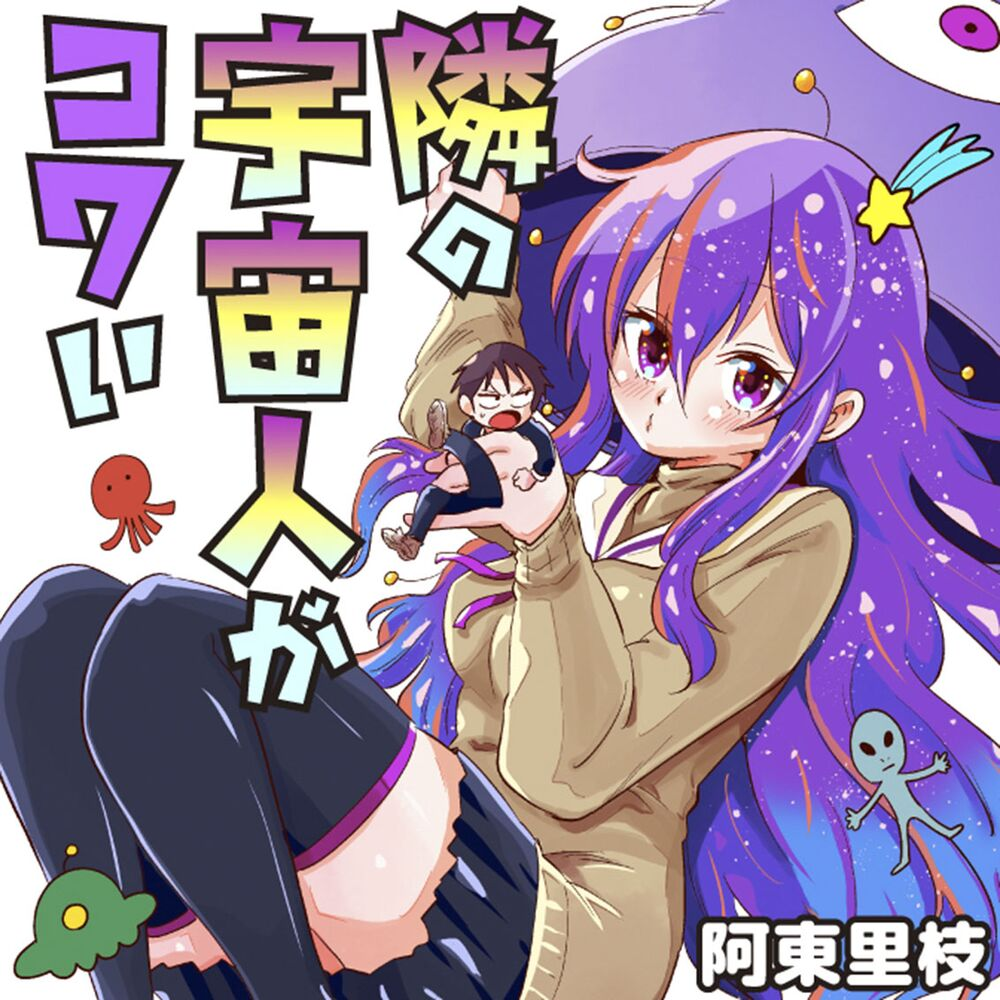

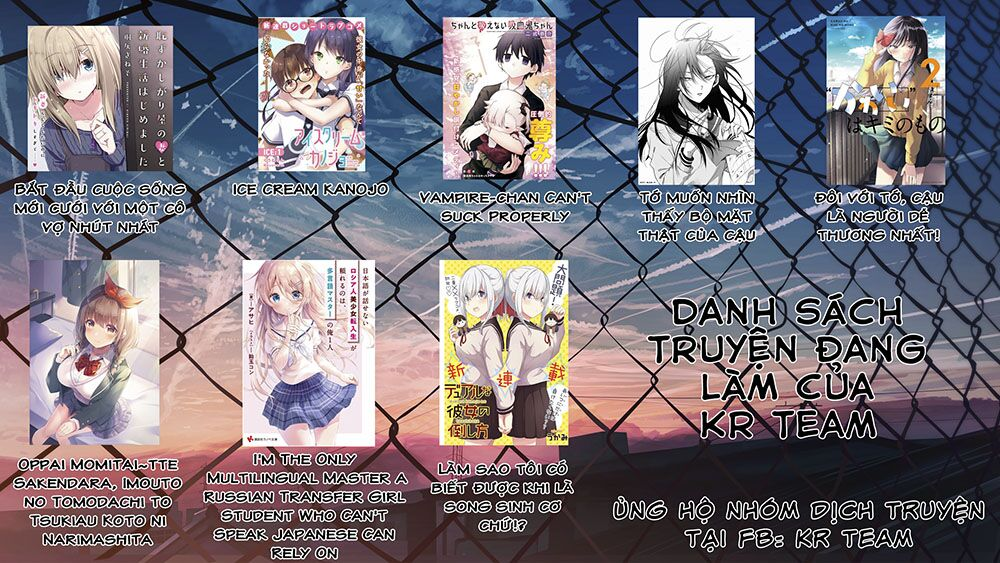

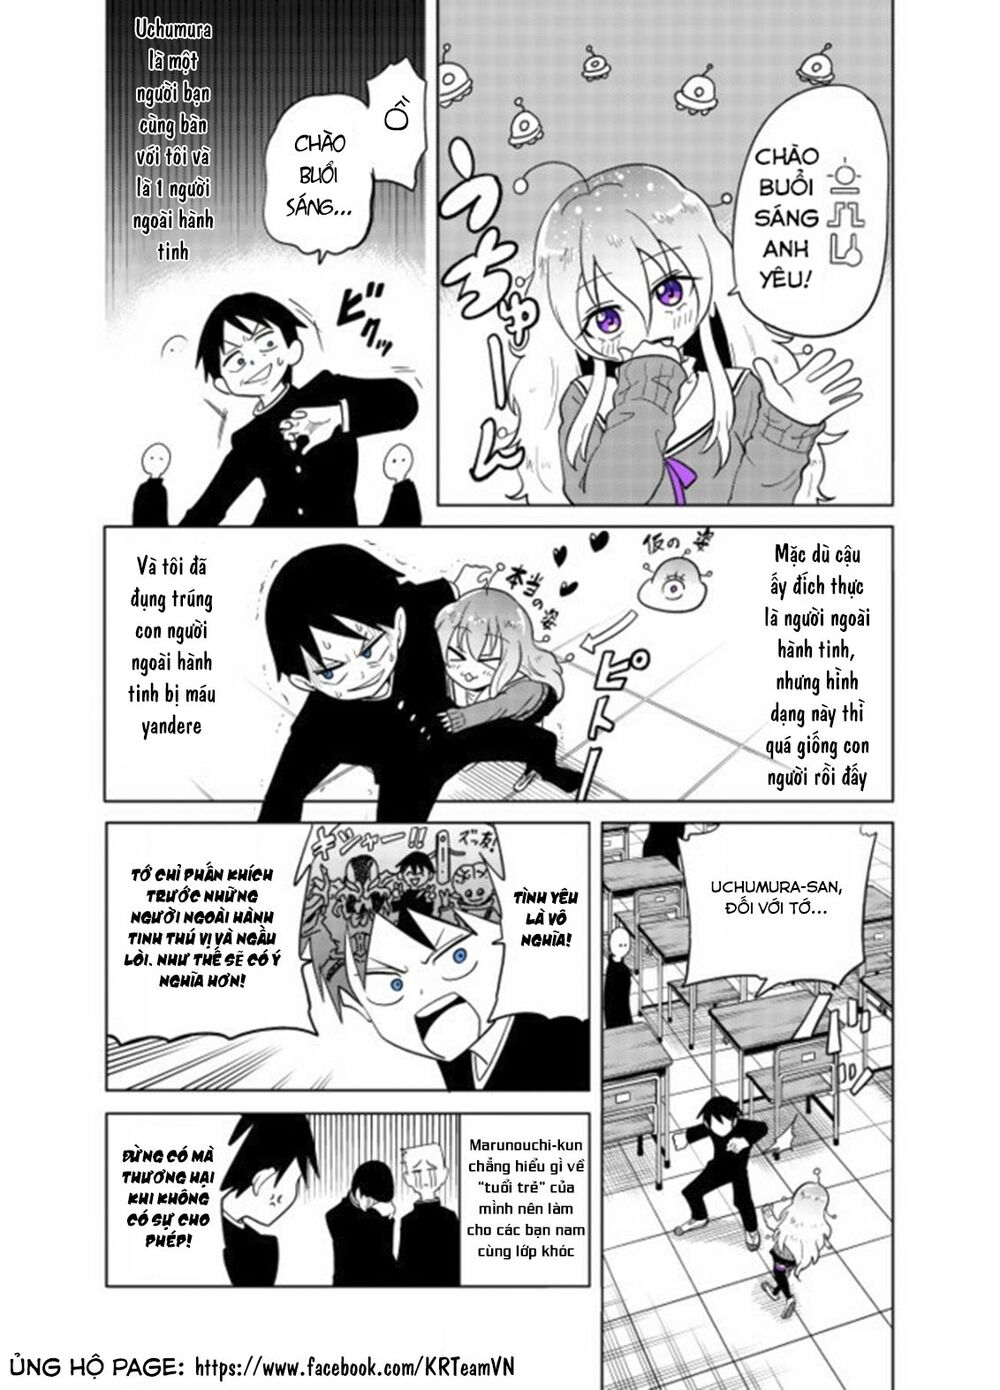

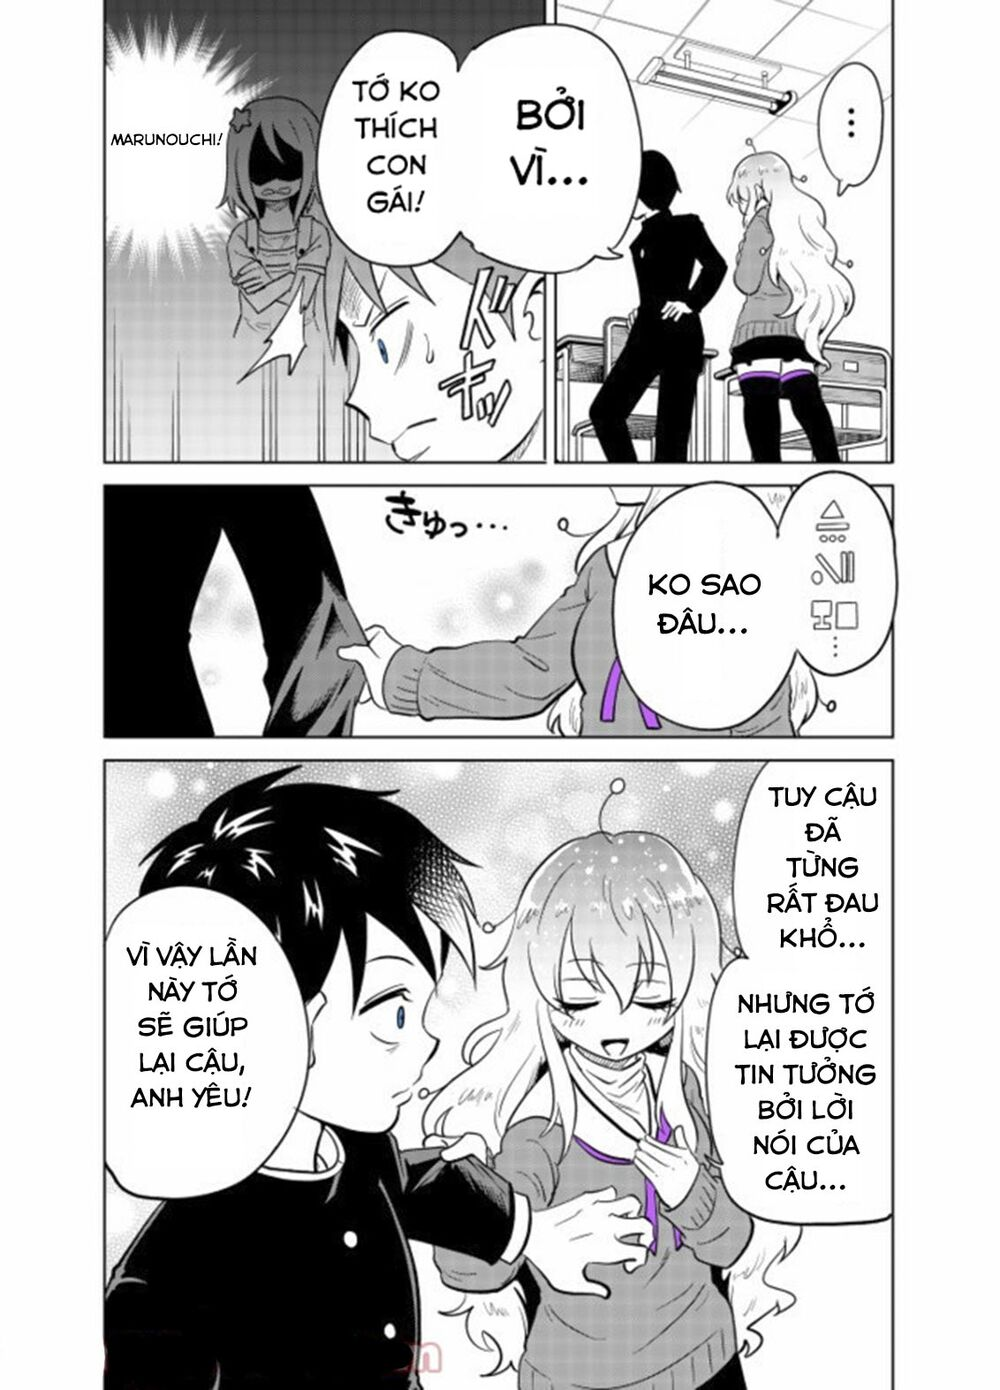

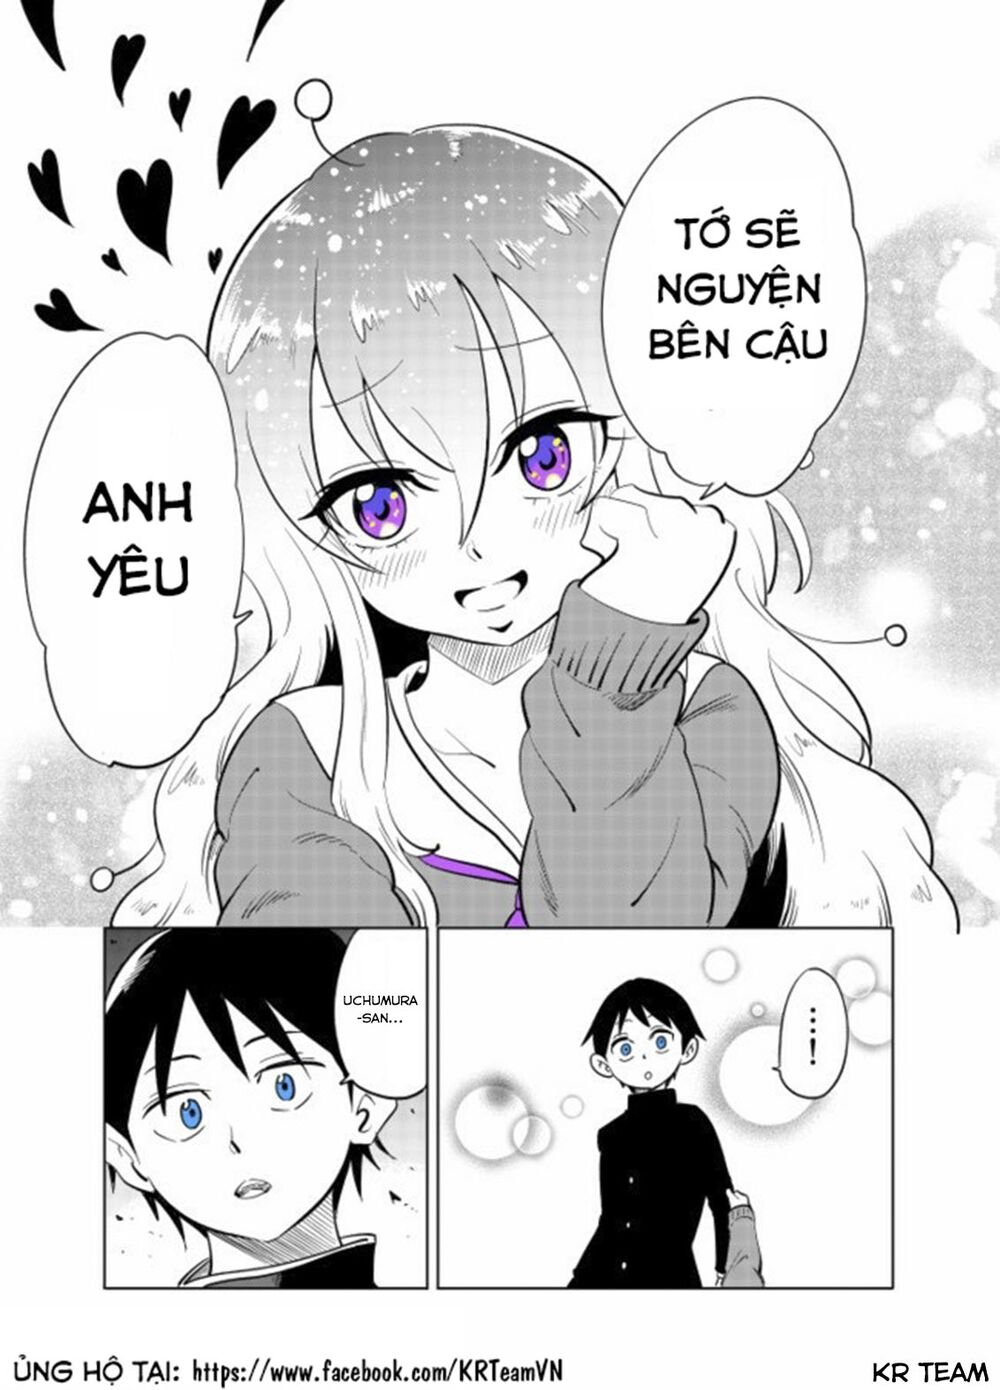

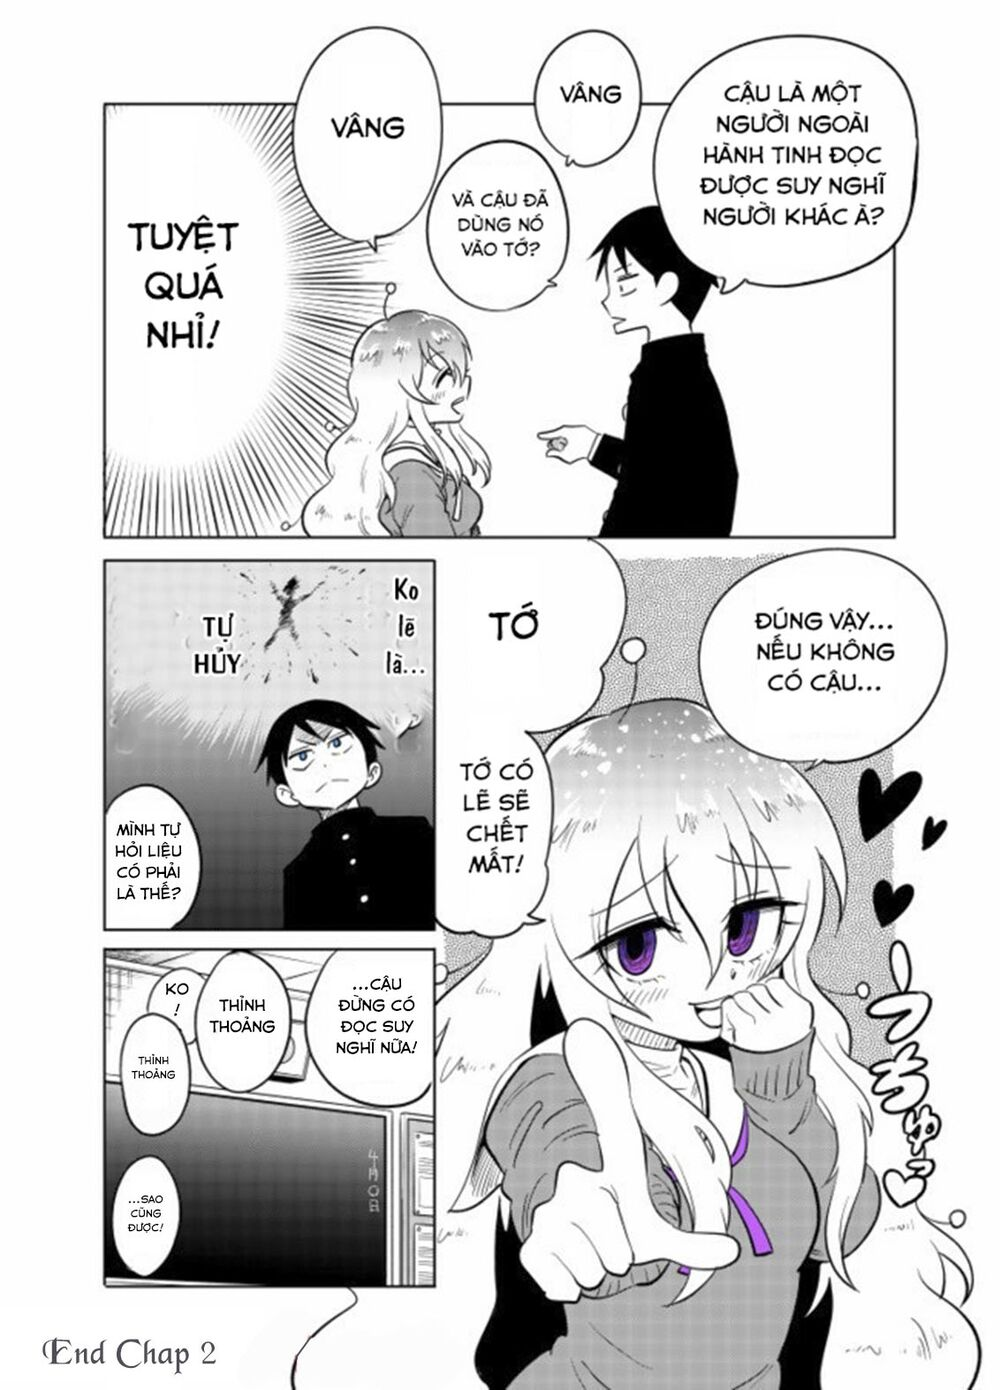

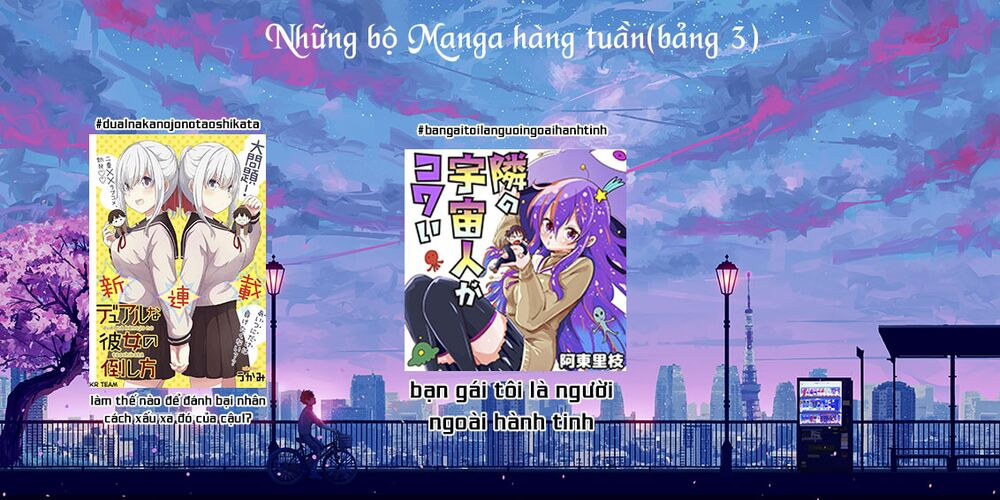

In [162]:
from glob import glob
chapter_dir = comic.chapters[0]
chapter_pages = glob(f"{chapter_dir}/*.jpg")
chapter_pages.sort()
for chapter_page in chapter_pages:
  img = cv2.imread(chapter_page)
  cv2_imshow(img)

**show 10 users scraped from comments**

In [151]:
for user in list(User.all_users)[:10]:
  print(user)

Name: DUYFA13 | Level: -1 | EXP: -1
Name: kkkk | Level: Cấp 1 | EXP: 0%
Name: abcxyz | Level: -1 | EXP: -1
Name: jinx | Level: -1 | EXP: -1
Name: jane applesead | Level: Cấp 1 | EXP: 0%
Name: minmin mikavi | Level: Cấp 1 | EXP: 0%
Name: Kikyo | Level: Cấp 1 | EXP: 0%
Name: Bui Duc Tinh | Level: Cấp 1 | EXP: 0%
Name: Phạm Phương | Level: Cấp 1 | EXP: 0%
Name: tran thuy nga | Level: Cấp 1 | EXP: 0%
